# Installation

In [ ]:
%conda clean --all
%pip install pydicom
%pip install opencv-python --user
%pip install tensorflow --user

# Import Libraries

In [57]:
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import pydicom
# import cv2
import os
import glob
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Activation, Dense
from keras.models import Sequential
from keras.callbacks import History
import cv2
import random
# from keras.layers import LeakyReLU
# from sklearn.metrics import confusion_matrix
import fnmatch
import copy

# Load Data

### Folder Structure

Due to the sheer size of data (13 GB total), the data is not included in the github repository. I have the code set up such that, after you perform git clone(repo), you will create a folder called `BMEN509-Project`. In the same directory housing `BMEN509-Project`, create a new folder `data`. In the folder `data` create two subfolders: `cancer` and `notcancer`. These will house the cancerous images and the not cancerous images for the training model.

To import the model, you need to open the two files: `StageII-Colorectal-CT_v1.tcia` and `TCIA-Pelvic-Reference-Data.tcia`. 
    * `StageII-Colorectal-CT_v1.tcia` corresponds to the cancerous dataset. Downlaod the entire dataset into the `cancer` image folder previously created. I downloaded it using the NBIA data retriever
    * `TCIA-Pelvic-Reference-Data.tcia` corresponds to the not cancerous dataset. Download the entire dataset into the `not cancer` folder.

Double check that the directory pathways match (the variable `cancer_data_directory` and `notcancer_data_directory` below), as the created manifest number can vary.

## Cancer Data Filtering

The aim of this section is to help modify the input data for better accuracy in the cnn. 

For the cancer dataset, the images are grouped by patient - but the original cnn model handled each image as though it was its own patient. Grouping the data can help the model to have the full spectrum of images as input, and help reduce inaccuracy where images do not have appropriate cancer classification features.

Furthermore, the cancer dataset has both pelvic and abdominal ct scans. To further improve accuracy, the abdominal scans will be removed, as the not cancerous dataset is exclusively pelvic data.

In [58]:
# Define the base directories
base_directory = '../data'
cancer_data_directory = base_directory + '/cancer/manifest-1646429317311/StageII-Colorectal-CT'


In [59]:
# Recursively look through all folders for dicom files
def find_files(directory, pattern):
    '''Given a directory and a filename pattern, recursively find all files that match in that directory.'''
    matches = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            matches.append(os.path.join(root, filename))
    return matches


In [60]:
# Get all the folders to iterate through, sorted by patient number
folders = []
for dir in os.listdir(cancer_data_directory):
    if dir.startswith('Stage'):
        folders.append(dir)

folders.sort()

In [61]:
# Find & list files
all_cancer_files = []

for dir in folders:
    if dir.startswith('StageII-Colorectal-CT-'):
        all_cancer_files.append(find_files((cancer_data_directory + '/' + dir), '*.dcm'))

# Sort the files by dicom number and get total file number
num_cancer_files = 0
for i, patient in enumerate(all_cancer_files):
    all_cancer_files[i].sort()
    for img in patient:
        num_cancer_files += 1

print('Found a total of {} patients.'.format(len(all_cancer_files)))
print('Found a total of {} files.'.format(num_cancer_files))


Found a total of 230 patients.
Found a total of 13850 files.


## Examine one patient

We will look at one patient in the in the dataset to analyze proper input parsing

In [62]:
# Define the patient number from the file name
patient_num = '001'

In [63]:
patient_num = int(patient_num) - 1
print('Found {} files for patient {}.'.format(len(all_cancer_files[patient_num]), patient_num + 1))

# Print the first files
print_index = 5
print('\nPrinting the first {} cancer files:'.format(print_index))
for i in range(print_index):
    print(all_cancer_files[patient_num][i])



Found 90 files for patient 1.

Printing the first 5 cancer files:
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-001/09-14-2003-NA-Abdomen CT RoutineEnhanced-11625/5.000000-Venous Phase  5.0  B30f-12095/1-01.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-001/09-14-2003-NA-Abdomen CT RoutineEnhanced-11625/5.000000-Venous Phase  5.0  B30f-12095/1-02.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-001/09-14-2003-NA-Abdomen CT RoutineEnhanced-11625/5.000000-Venous Phase  5.0  B30f-12095/1-03.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-001/09-14-2003-NA-Abdomen CT RoutineEnhanced-11625/5.000000-Venous Phase  5.0  B30f-12095/1-04.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-001/09-14-2003-NA-Abdomen CT RoutineEnhanced-11625/5.000000-Venous Phase  5.0  B30f-12095/1-05.dcm


### Create dicom array to hold data

In [64]:
# Load the files into a 3D array
RefDs = pydicom.read_file(all_cancer_files[patient_num][0])
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns),len(all_cancer_files[patient_num]))

# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Put image information in pixel array
for z in range(len(all_cancer_files[patient_num])):
    RefDs = pydicom.read_file(all_cancer_files[patient_num][z])
    ArrayDicom[:,:,z]=RefDs.pixel_array


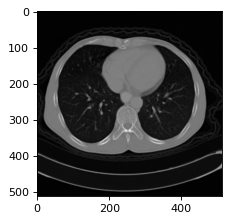

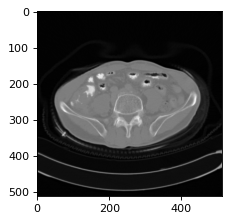

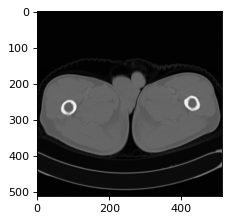

In [65]:
# Display the first, middle, and last image to see what body parts are displayed

# First
plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='b')
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ArrayDicom[:,:,0], cmap=plt.cm.gray)
plt.show()

# Middle 
plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='b')
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ArrayDicom[:,:, int(len(all_cancer_files[patient_num])/2) ], cmap=plt.cm.gray)
plt.show()

# Last 
plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='b')
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ArrayDicom[:,:, len(all_cancer_files[patient_num])-1 ], cmap=plt.cm.gray)
plt.show()

# Image Inspection

The dataset contains both pelvic and abdominal CT scans. We shall examin the dicom data for the patient to determine if all images in one folder correspond to the same patient or correspond to the same body part.

In [66]:
ds = pydicom.read_file(all_cancer_files[0][0])

# Print the CT data information
print("Patient ID: {}".format(ds.PatientID))
print("Body Part Examined: {}".format(ds.BodyPartExamined))

print('\nIterating through all images to determine if there are multiple patients or body parts')

different = False
# Put image information in pixel array
for z in range(len(all_cancer_files[0])):
    t_ds = pydicom.read_file(all_cancer_files[0][z])
    if t_ds.PatientID != ds.PatientID:
        print('Found a new patient id: {}'.format(t_ds.PatientID))
        different = True
    if t_ds.BodyPartExamined != ds.BodyPartExamined:
        print('Found a new examined body part: {}'.format(t_ds.BodyPartExamined))
        different = True

if not different:
    print('All images correspond to the same patient ID and the same body part')
    
    

Patient ID: StageII-Colorectal-CT-001
Body Part Examined: ABDOMEN

Iterating through all images to determine if there are multiple patients or body parts
All images correspond to the same patient ID and the same body part


The output above shows that all images belong to the same patient, and belong to the same body part.

Further inspection into the data source demonstrates that 47% of the data examines the pelvic area, while 52% of the data examines the abdominal area. There are a total of 230 cases, 230 studies, and 230 series in this cohort, with an unknown number of patients. We will continue to examine the data further using the DICOM data.

As there are 230 patient folders, it is believed that each folder contains a unique patient - where 47% had the pelvic area examined, and 52% had the abdominal area. The code below will prove this hypothesis.

In [67]:
body_parts = []
patient_ids = []
for patient in all_cancer_files:
    ds = pydicom.read_file(patient[0])
    if ds.PatientID not in patient_ids:
        patient_ids.append(ds.PatientID)
    if ds.BodyPartExamined not in body_parts:
        body_parts.append(ds.BodyPartExamined)

print('Printing all body parts: ', end='')
for body_part in body_parts:
    print(body_part, end=' ')

print('\nFound {} unique patients of {} unique folders.'.format(len(patient_ids), len(all_cancer_files)))

Printing all body parts: ABDOMEN PELVIS 
Found 230 unique patients of 230 unique folders.


As per the results of the code above, the two different body parts examined by the CT scnas are the abdomen and the pelvis for this dataset, which corresponds with the expected results of the dataset. Furthermore, every folder contains a unique patient ID, meaning that the same patient is not repeated multiple times.

The next step is to filter out all unwanted body parts (the abdomen CT scans) and confirm that we have an expected number of remaining patients with only pelvic scans.

In [68]:
t_all_cancer_files = copy.deepcopy(all_cancer_files)
all_cancer_files = []

for patient in t_all_cancer_files:
    ds = pydicom.read_file(patient[0])
    if ds.BodyPartExamined == 'PELVIS':
        all_cancer_files.append(patient)

# Sort the files by dicom number and get total file number
num_cancer_files = 0
for i, patient in enumerate(all_cancer_files):
    all_cancer_files[i].sort()
    for img in patient:
        num_cancer_files += 1

print('Found a total of {} patients with pelvic CT scans.'.format(len(all_cancer_files)))
print('Found a total of {} files.'.format(num_cancer_files))

Found a total of 110 patients with pelvic CT scans.
Found a total of 6247 files.


110 patients were found to have pelvic CT scans. This is 47.8% of the total patients, corresponding with the rounded 47%. Now, all unwanted data has been filtered out from the cancerous patient dataset.

# Not Cancerous Dataset

Again, the reference data CT scans are grouped by patient - and thus the model should be fed these scans as one set.

In [69]:
notcancer_data_directory = base_directory + '/notcancer/manifest-1568393181203/Pelvic-Reference-Data'

In [70]:
# Get all the folders to iterate through, sorted by patient number
folders = []
for dir in os.listdir(notcancer_data_directory):
    if dir.startswith('Pelvic'):
        folders.append(dir)

folders.sort()

In [71]:
# Find & list files
all_not_cancer_files = []

for dir in folders:
    if dir.startswith('Pelvic-Ref-'):
        all_not_cancer_files.append(find_files((notcancer_data_directory + '/' + dir), '*.dcm'))

# Sort the files by dicom number and get total file number
num_not_cancer_files = 0
for i, patient in enumerate(all_not_cancer_files):
    all_not_cancer_files[i].sort()
    for img in patient:
        num_not_cancer_files += 1

print('Found a total of {} patients.'.format(len(all_not_cancer_files)))
print('Found a total of {} files.'.format(num_not_cancer_files))

Found a total of 58 patients.
Found a total of 13644 files.


## Examine one patient

We will look at one patient in the in the dataset to analyze proper input parsing

In [72]:
# Define the patient number from the file name
patient_num = '001'

In [73]:
patient_num = int(patient_num) - 1
print('Found {} files for patient {}.'.format(len(all_not_cancer_files[patient_num]), patient_num + 1))

# Print the first files
print_index = 5
print('\nPrinting the first {} cancer files:'.format(print_index))
for i in range(print_index):
    print(all_not_cancer_files[patient_num][i])

Found 241 files for patient 1.

Printing the first 5 cancer files:
../data/notcancer/manifest-1568393181203/Pelvic-Reference-Data/Pelvic-Ref-001/11-14-2012-NA-PRONE ANUS-53967/47654.000000-NewSimCT-65447/1-001.dcm
../data/notcancer/manifest-1568393181203/Pelvic-Reference-Data/Pelvic-Ref-001/11-14-2012-NA-PRONE ANUS-53967/47654.000000-NewSimCT-65447/1-002.dcm
../data/notcancer/manifest-1568393181203/Pelvic-Reference-Data/Pelvic-Ref-001/11-14-2012-NA-PRONE ANUS-53967/47654.000000-NewSimCT-65447/1-003.dcm
../data/notcancer/manifest-1568393181203/Pelvic-Reference-Data/Pelvic-Ref-001/11-14-2012-NA-PRONE ANUS-53967/47654.000000-NewSimCT-65447/1-004.dcm
../data/notcancer/manifest-1568393181203/Pelvic-Reference-Data/Pelvic-Ref-001/11-14-2012-NA-PRONE ANUS-53967/47654.000000-NewSimCT-65447/1-005.dcm


### Create dicom array to hold data

In [74]:
# Load the files into a 3D array
RefDs = pydicom.read_file(all_not_cancer_files[patient_num][0])
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns),len(all_not_cancer_files[patient_num]))

# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Put image information in pixel array
for z in range(len(all_not_cancer_files[patient_num])):
    RefDs = pydicom.read_file(all_not_cancer_files[patient_num][z])
    ArrayDicom[:,:,z]=RefDs.pixel_array


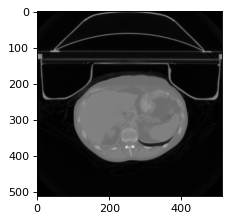

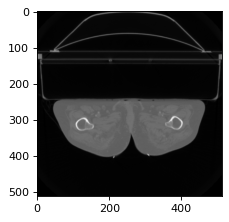

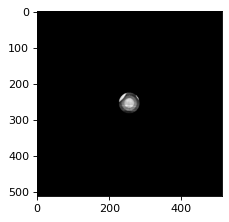

In [75]:
# Display the first, middle, and last image to see what body parts are displayed

# First
plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='b')
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ArrayDicom[:,:,0], cmap=plt.cm.gray)
plt.show()

# Middle 
plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='b')
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ArrayDicom[:,:, int(len(all_not_cancer_files[patient_num])/2) ], cmap=plt.cm.gray)
plt.show()

# Last 
plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='b')
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ArrayDicom[:,:, len(all_not_cancer_files[patient_num])-1 ], cmap=plt.cm.gray)
plt.show()

# Image Inspection

The dataset contains pelvic, chest, and abdominal CT scans. We shall examin the dicom data for the patient to determine if all images in one folder correspond to the same patient or correspond to the same body part.

In [76]:
ds = pydicom.read_file(all_not_cancer_files[0][0])

# Print the CT data information
print("Patient ID: {}".format(ds.PatientID))
print("Protocol Examined: {}".format(ds.ProtocolName))

print('\nIterating through all images to determine if there are multiple patients or protocols')

different = False
other_protocols = [ds.ProtocolName]
# Put image information in pixel array
for z in range(len(all_not_cancer_files[0])):
    t_ds = pydicom.read_file(all_not_cancer_files[0][z])
    if t_ds.PatientID != ds.PatientID:
        print('Found a new patient id: {}'.format(t_ds.PatientID))
        different = True
    if t_ds.ProtocolName not in other_protocols:
        other_protocols.append(t_ds.ProtocolName)
        different = True

if not different:
    print('All images correspond to the same patient ID and the same protocol')
elif len(other_protocols) > 1:
    print('New protocol: ' + other_protocols[1])

Patient ID: Pelvic-Ref-001
Protocol Examined: Onco Pelvis/OncoBody

Iterating through all images to determine if there are multiple patients or protocols
New protocol: fa_BodyM20-CW : M20 - Med_Res


The output above shows that all images belong to the same patient, but they belong to different protocols. There is the standard pelvic reference data, which corresponds to the pelvic, and the fa_body reference data, which corresponds to the upper body. The code below ensures that the patient ids are uniquely and properly stored, and that there is no additional body parts.

In [77]:
body_parts = []
patient_ids = []
for patient in all_not_cancer_files:
    for img in patient:
        ds = pydicom.read_file(img)
        if ds.PatientID not in patient_ids:
            patient_ids.append(ds.PatientID)
        if ds.ProtocolName not in body_parts:
            body_parts.append(ds.ProtocolName)

print('Printing all body parts: ')
for body_part in body_parts:
    print('\t',body_part)

print('\nFound {} unique patients of {} unique folders.'.format(len(patient_ids), len(all_not_cancer_files)))

Printing all body parts: 
	 Onco Pelvis/OncoBody
	 fa_BodyM20-CW : M20 - Med_Res
	 ABDOMEN_PELVIS /ONCOLOGY
	 VISI COIL PELVIS (2MM.)/OncoBody
	 Onco Pelvis /SH
	 fd_BodyM20-LoDose-CC : M20 - Med_Res
	 WBHPELVIS
	 fc_BodyM20-LoDose-CW : M20 - Med_Res
	 fb_BodyM20-CC : M20 - Med_Res
	 XVI Synergy
	 ONCO CNS/OncoBody
	 SARCOMA /ONCOLOGY

Found 58 unique patients of 58 unique folders.


As per the results of the code above, there are numerous different body parts contained within the reference data. There are four different classifications of pelvis data body parts, each with the word 'pelvis' in it. Furthermore, every folder contains a unique patient ID, meaning that the same patient is not repeated multiple times.

The next step is to filter out all inappropriate body part images.

In [78]:
t_all_not_cancer_files = copy.deepcopy(all_not_cancer_files)
all_not_cancer_files = []

for patient in t_all_not_cancer_files:
    imgs = []
    for img in patient:
        ds = pydicom.read_file(img)
        if 'pelvis' in ds.ProtocolName.lower():
            imgs.append(img)
    if len(imgs) > 0:
        all_not_cancer_files.append(imgs)

# Sort the files by dicom number and get total file number
num_not_cancer_files = 0
for i, patient in enumerate(all_not_cancer_files):
    all_not_cancer_files[i].sort()
    for img in patient:
        num_not_cancer_files += 1

print('Found a total of {} patients with pelvic CT scans.'.format(len(all_not_cancer_files)))
print('Found a total of {} files.'.format(num_not_cancer_files))

Found a total of 56 patients with pelvic CT scans.
Found a total of 8280 files.


We will then display one image of each type of body part to ensure that they are appropriate for the data model.

Printing all body parts: 
	 Onco Pelvis/OncoBody
	 ABDOMEN_PELVIS /ONCOLOGY
	 VISI COIL PELVIS (2MM.)/OncoBody
	 Onco Pelvis /SH
	 WBHPELVIS
Onco Pelvis/OncoBody


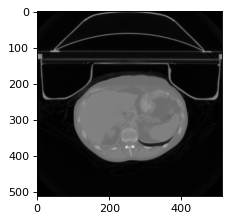

ABDOMEN_PELVIS /ONCOLOGY


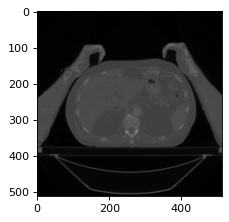

VISI COIL PELVIS (2MM.)/OncoBody


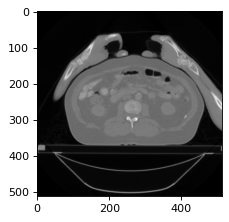

Onco Pelvis /SH


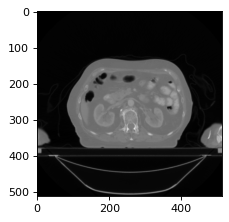

WBHPELVIS


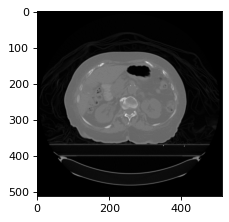

In [79]:
body_parts = []
not_cancer_sub_images = []
for patient in all_not_cancer_files:
    for img in patient:
        ds = pydicom.read_file(img)
        if ds.ProtocolName not in body_parts:
            body_parts.append(ds.ProtocolName)
            not_cancer_sub_images.append(img)

# Load the files into a 3D array
RefDs = pydicom.read_file(not_cancer_sub_images[0])
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns),len(not_cancer_sub_images))

# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Put image information in pixel array
for z in range(len(not_cancer_sub_images)):
    RefDs = pydicom.read_file(not_cancer_sub_images[z])
    ArrayDicom[:,:,z]=RefDs.pixel_array

print('Printing all body parts: ')
for body_part in body_parts:
    print('\t',body_part)

# Display each image
for z in range(len(not_cancer_sub_images)):
    print(body_parts[z])
    plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='b')
    plt.set_cmap(plt.gray()) #grayscale
    plt.imshow(ArrayDicom[:,:,z], cmap=plt.cm.gray)
    plt.show()

As all of the images are appropriately displaying pelvic data, they will all stay in the dataset.

In [80]:
# Final dataset with correct body parts
print('Found a total of {} patients with pelvic CT scans with cancer.'.format(len(all_cancer_files)))
print('Found a total of {} files with cancer.'.format(num_cancer_files))
print('Found a total of {} patients with pelvic CT scans without cancer.'.format(len(all_not_cancer_files)))
print('Found a total of {} files without cancer.'.format(num_not_cancer_files))

Found a total of 110 patients with pelvic CT scans with cancer.
Found a total of 6247 files with cancer.
Found a total of 56 patients with pelvic CT scans without cancer.
Found a total of 8280 files without cancer.


### Unravel the data

Ideally the data should be left packaged and fed in together, but there would need to be ~10 packages, which contain ~150 images per package in the non-cancer form, and ~50 images per package in the cancer form, which is too comupationally complex for local systems at this time. This will help show model accuracy increase with more accurate input images.

In [81]:
all_cancer_files = [element for row in all_cancer_files for element in row]
all_not_cancer_files = [element for row in all_not_cancer_files for element in row]

print(len(all_cancer_files))
print(len(all_not_cancer_files))

if len(all_cancer_files) != num_cancer_files or len(all_not_cancer_files) != num_not_cancer_files:
    print('\033[31mError: Did not successfully unravel the arrays.\033[0m')
    raise SystemExit

6247
8280


# Create Subset of the Data
For this code, made the number of cancer and not cancer images always the same - if there are n cancer images presented to the model, there will also be n not cancer images presented to the model. In a real-life setting, this classification would most likely be used in an environment where patients are believed to have cancer (enough to be screened), and, thus, a 1-1 ratio might not be accurate for a real life example. However, this ratio provides a fair dataset for the model to train on.

We subset the data to only train the model on part of the files. The files are randomized before being selected, to ensure the model doesn't always train on the same data (which helps demonstrate the usability of the overall model). A subset is used as our computers are not efficient at handling the entire dataset - but, ideally, this model would train on the entire dataset.

In [84]:
# Shuffle the data
random.shuffle(all_cancer_files)
# for i, _ in enumerate(all_cancer_files):
#     random.shuffle(all_cancer_files[i])

random.shuffle(all_not_cancer_files)
# for i, _ in enumerate(all_not_cancer_files):
#     random.shuffle(all_not_cancer_files[i])

# Print the first files to show that it was shuffled
print('\nPrinting the first {} cancer files after shuffling:'.format(print_index))
for i in range(print_index):
    print(all_cancer_files[i])
print('\nPrinting the first {} not cancer files after shuffling:'.format(print_index))
for i in range(print_index):
    print(all_not_cancer_files[i])



Printing the first 5 cancer files after shuffling:
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-041/05-05-2005-NA-Pelvic Cavity CT RoutineEnhanced-21772/2.000000-Pelvis  5.0  B31f-39559/1-46.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-071/12-09-2005-NA-Pelvic Cavity CT RoutineEnhanced-23594/2.000000-Pelvis  5.0  B31f-93312/1-26.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-145/01-20-2007-NA-Pelvic Cavity CT Routine-88126/2.000000-NA-01998/1-09.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-127/10-14-2006-NA-Pelvic Cavity CT RoutineEnhanced-27778/2.000000-Pelvis  5.0  B31f-37560/1-48.dcm
../data/cancer/manifest-1646429317311/StageII-Colorectal-CT/StageII-Colorectal-CT-044/05-21-2005-NA-Pelvic Cavity CT RoutineEnhanced-20315/2.000000-NA-86219/1-59.dcm

Printing the first 5 not cancer files after shuffling:
../data/notcancer/manifes

In [85]:
# subset_num is the number of files extracted from each dataset. 
# Thus, if subset_num = 50, the model will be trained on 50*2=100 images
subset_num = 100
cancer_files = all_cancer_files[0:subset_num]
notcancer_files = all_not_cancer_files[0:subset_num]

if len(cancer_files) != subset_num or len(notcancer_files) != subset_num:
    print('\033[31mError: do not have enough files to satisfy the subset number.\033[0m')
    raise SystemExit

print('Using {} cancer files and {} notcancer files.'.format(len(cancer_files), len(notcancer_files)))

Using 100 cancer files and 100 notcancer files.


In [86]:
# Load the files into a 3D array
cancer_RefDs = pydicom.read_file(cancer_files[0])
notcancer_RefDs = pydicom.read_file(notcancer_files[0])
cancer_ConstPixelDims = (int(cancer_RefDs.Rows), int(cancer_RefDs.Columns),subset_num)
notcancer_ConstPixelDims = (int(notcancer_RefDs.Rows), int(notcancer_RefDs.Columns),subset_num)

# Then initialize in zeros an array
cancer_ArrayDicom = np.zeros(cancer_ConstPixelDims, dtype=cancer_RefDs.pixel_array.dtype)
notcancer_ArrayDicom = np.zeros(notcancer_ConstPixelDims, dtype=notcancer_RefDs.pixel_array.dtype)

# Put image information in pixel array
for z in range(subset_num):
    cancer_RefDs = pydicom.read_file(cancer_files[z])
    notcancer_RefDs = pydicom.read_file(notcancer_files[z])
    cancer_ArrayDicom[:,:,z]=cancer_RefDs.pixel_array
    notcancer_ArrayDicom[:,:,z]=notcancer_RefDs.pixel_array


#### Load the first 6 images of each dataset 

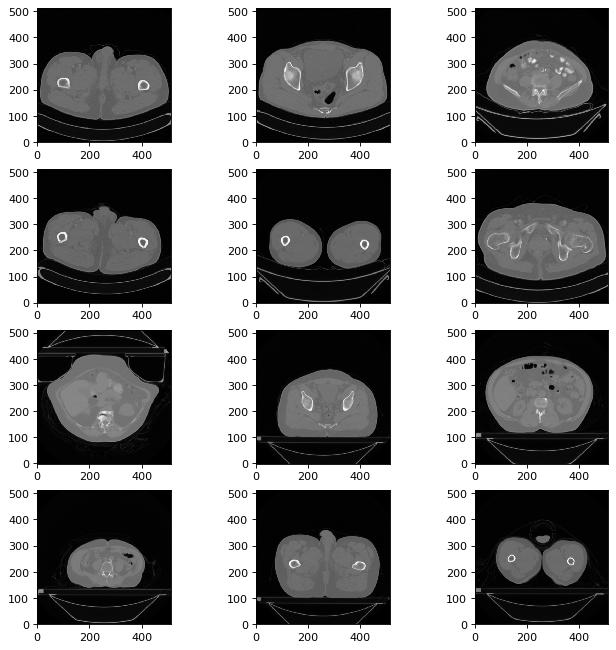

In [87]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='b')
plt.set_cmap(plt.gray()) #grayscale

# Set horizontal and vertical axes for colormesh
cancer_Rows=np.arange(cancer_RefDs.Rows)
notcancer_Rows=np.arange(notcancer_RefDs.Rows)
cancer_Columns=np.arange(cancer_RefDs.Columns)
notcancer_Columns=np.arange(notcancer_RefDs.Columns)

# Render the images
num_cols = 3
num_rows = 2
for y in range(num_rows):
    for x in range(num_cols):
        plt.subplot(num_rows*2, num_cols, y * num_cols + x + 1)
        plt.gca().set_aspect('equal')
        plt.pcolormesh(cancer_Rows, cancer_Columns, np.flipud(cancer_ArrayDicom[:, :,y*num_cols+x]))

for y in range(num_rows):
    for x in range(num_cols):
        plt.subplot(num_rows * 2, num_cols, (y + num_rows) * num_cols + x + 1)
        plt.gca().set_aspect('equal')
        plt.pcolormesh(notcancer_Rows, notcancer_Columns, np.flipud(notcancer_ArrayDicom[:, :,y*num_cols+x]))


# Data Preprocessing

### Define Model Size Parameter

We have to identify the model expected input shape to properly develop the CNN mask. We need to make the expected input shape match the input size of the images - thus this model parameter is defined earlier

In [88]:
input_shape = (450, 600, 1)
new_size = (input_shape[0], input_shape[1])

In [89]:
print('Shape Before:', cancer_ArrayDicom.shape)

# Resize the images
cancer_ArrayDicom_resized = np.zeros((new_size[0], new_size[1], subset_num), dtype=cancer_ArrayDicom.dtype)
notcancer_ArrayDicom_resized = np.zeros((new_size[0], new_size[1], subset_num), dtype=notcancer_ArrayDicom.dtype)
for z in range(subset_num):
    cancer_ArrayDicom_resized[:, :, z] = cv2.resize(cancer_ArrayDicom[:, :, z], new_size).T
    notcancer_ArrayDicom_resized[:, :, z] = cv2.resize(notcancer_ArrayDicom[:, :, z], new_size).T

print('Shape After', cancer_ArrayDicom_resized.shape)

if cancer_ArrayDicom_resized.shape[0] != input_shape[0] or notcancer_ArrayDicom_resized.shape[0] != input_shape[0] \
    or cancer_ArrayDicom_resized.shape[1] != input_shape[1] or notcancer_ArrayDicom_resized.shape[1] != input_shape[1] \
    or cancer_ArrayDicom_resized.shape[2] != subset_num or notcancer_ArrayDicom_resized.shape[2] != subset_num:
    print('\033[31mError: the images did not appropriately resize to their expected input shape.\033[0m')
    raise SystemExit

Shape Before: (512, 512, 100)
Shape After (450, 600, 100)


### Model Train / Test Parameter Processing
The model will always train on an equal partition of each class, to ensure an appropriate dataset for each class classification. That is, we will input the same number of cancer and not cancer images into the model for training. This has a major impact on smaller training sizes. In a real-world setting, we can control the training model, and thus this is accurate to the real-world setting. However, due to the code having even numbers of cancer and not cancer images, this will also force the test data to be a perfect split. This is not accurate to the real-world setting, and may impact the results.

In [90]:
# The percent of data used for training. 
# train_percent of 0.5 means 50% of the data will be used for training
train_percent = 0.5

num_slices = cancer_ArrayDicom_resized.shape[2]
num_slices_to_train = int(num_slices * train_percent)

cancer_X_train = cancer_ArrayDicom_resized[:, :, :num_slices_to_train]
notcancer_X_train = notcancer_ArrayDicom_resized[:, :, :num_slices_to_train]
cancer_X_test = cancer_ArrayDicom_resized[:, :, :-(num_slices - num_slices_to_train)]
notcancer_X_test = notcancer_ArrayDicom_resized[:, :, :-(num_slices - num_slices_to_train)]

# Scale images to the [0, 1] range
cancer_X_train = cancer_X_train.astype("float32") / 255
notcancer_X_train = notcancer_X_train.astype("float32") / 255
cancer_X_test = cancer_X_test.astype("float32") / 255
notcancer_X_test = notcancer_X_test.astype("float32") / 255

# Make sure images have appropriate shape
cancer_X_train = np.expand_dims(cancer_X_train, -1)
notcancer_X_train = np.expand_dims(notcancer_X_train, -1)
cancer_X_test = np.expand_dims(cancer_X_test, -1)
notcancer_X_test = np.expand_dims(notcancer_X_test, -1)

# Transpose the shape
cancer_X_train = np.transpose(cancer_X_train, (2, 0, 1, 3))
notcancer_X_train = np.transpose(notcancer_X_train, (2, 0, 1, 3))
cancer_X_test = np.transpose(cancer_X_test, (2, 0, 1, 3))
notcancer_X_test = np.transpose(notcancer_X_test, (2, 0, 1, 3))

print("X_train shape:", cancer_X_train.shape)
print(cancer_X_train.shape[0] + notcancer_X_train.shape[0], "train samples")
print(cancer_X_test.shape[0] + notcancer_X_test.shape[0], "test samples")

if cancer_X_train.shape[1] != input_shape[0] or notcancer_X_train.shape[1] != input_shape[0] \
    or cancer_X_train.shape[2] != input_shape[1] or notcancer_X_train.shape[2] != input_shape[1] \
    or cancer_X_test.shape[1] != input_shape[0] or notcancer_X_test.shape[1] != input_shape[0] \
    or cancer_X_test.shape[2] != input_shape[1] or notcancer_X_test.shape[2] != input_shape[1] \
    or cancer_X_train.shape[0] != num_slices_to_train or notcancer_X_train.shape[0] != num_slices_to_train \
    or cancer_X_test.shape[0] != num_slices - num_slices_to_train or notcancer_X_test.shape[0] != num_slices - num_slices_to_train \
    or cancer_X_test.shape[3] != input_shape[2] or notcancer_X_test.shape[3] != input_shape[2]: 
    print('\033[31mError: The images were not appropriately split into test and train categories.\033[0m')
    raise SystemExit



X_train shape: (50, 450, 600, 1)
100 train samples
100 test samples


In [91]:
cancer_Y = np.ones(subset_num)
notcancer_Y = np.zeros(subset_num)

if cancer_ArrayDicom_resized.shape[2] != cancer_Y.shape[0] or notcancer_ArrayDicom_resized.shape[2] != notcancer_Y.shape[0] \
    or cancer_Y.all() != 1 or notcancer_Y.all() != 0:
    print('\033[31mError: did not appropriately assign cancer_Y and notcancer_Y values.\033[0m')
    raise SystemExit

# Need to make the Y values match the x values
cancer_Y_train = cancer_Y[:num_slices_to_train]
notcancer_Y_train = notcancer_Y[:num_slices_to_train]
cancer_Y_test = cancer_Y[-(num_slices - num_slices_to_train):]
notcancer_Y_test = notcancer_Y[-(num_slices - num_slices_to_train):]

if len(cancer_X_train) != len(cancer_Y_train) or len(notcancer_X_train) != len(notcancer_Y_train) \
    or len(cancer_X_test) != len(cancer_Y_test) or len(notcancer_X_test) != len(notcancer_Y_test): 
    print('\033[31mError: The Y values were not appropriately assigned.\033[0m')
    raise SystemExit

print('Y samples appropriately assigned.')

Y samples appropriately assigned.


In [92]:
# Combine x and y values for cancer and not cancer datasets
cancer_train_data = list(zip(cancer_X_train, cancer_Y_train))
notcancer_train_data = list(zip(notcancer_X_train, notcancer_Y_train))
cancer_test_data = list(zip(cancer_X_test, cancer_Y_test))
notcancer_test_data = list(zip(notcancer_X_test, notcancer_Y_test))

# Combine both datasets into a single list
combined_train_data = cancer_train_data + notcancer_train_data
combined_test_data = cancer_test_data + notcancer_test_data

# Shuffle the combined list
random.shuffle(combined_train_data)
random.shuffle(combined_test_data)

# Separate the shuffled x and y values
X_train, Y_train = zip(*combined_train_data)
X_test, Y_test = zip(*combined_test_data)

# Convert the arrays to a usable format
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Convert Y_train and Y_test to integers instead of floats
Y_train = np.array(Y_train, dtype=int)
Y_test = np.array(Y_test, dtype=int)

print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (100, 450, 600, 1)
100 train samples
100 test samples


In [93]:
# Print the first few Y values to prove that they are shuffled
print('Y_train values:\t', end='')
for i in range(print_index):
    print('{}'.format(Y_train[i]), end='')
print('\nY_test values:\t', end='')
for i in range(print_index):
    print('{}'.format(Y_test[i]), end='')
print()


Y_train values:	01000
Y_test values:	00111


# Model Definition

Model information:
1. Input shape: the defined model has an input size, defined earlier, as (450, 600, 1). This means that the model expects images 450x600 pixels, with the 1 meaning that each image is identified exclusively in greyscale (single intensity value)
2. Layers: the defined model has 24 total layers
    * 14 convolutional layers. These are responsible for applying filters to the images, and converting the images into a feature map. Each filter recognizes a specific feature. 
        * All convolution layers use a relu activation function (setting negative values to 0). This activation function was chosen as a simple, non-linear activation function, as linear activation functions can only approximate linear relationships - not complex relationships. 
        * All convolution layers use a 3x3 kernel, enabling recognition of smaller features by looking at smaller areas. This decreases receptive fields, enabling each individual neuron to look at a smaller area. This helps the model notice smaller cancer-indicative features, but may prevent hte model from looking at features on a bigger level. Furthermore, larger kernels have a higher risk of overfitting, increased complexity, and a longer runtime.
        * The final value (64, 128, 256, 512, 1024) details the number of feature maps produced (ie how many features the layer can detect). The model is designed with an increasing produced feature map, identifying an incremental number of sub-features, and then decreasing the number of feature maps, helping to subsample and identify the necessary features for detection.
    * 4 max pooling layers. These reduce dimensionality of the feature maps, by taking the max value of the area (defined by the pool size). Pools are non-overlapping. 
        * In the below model, all max pooling layers have a pool size of 2x2 - thus, the image will be reduced by approximately 4x the number of pixels. This number ir proportional to the increase in feature maps between layers (where each convolution layer changes feature maps by a factor of 2).
        * Max pooling occurs when upsizing the image (making the next convolutional layer identify more feature maps). This helps the model subsample the required points to look at when identifying key features, helping increase runtime and decreasing minute details (such as speckle) from ruining the larger image.
    * 4 transpose convolutional layers. Upsamples the image to a higher resolution (helping to highlight features) using learned filters.
        * The transpose layers are placed before the model identifies a subset of feature maps. Transposition helps ensure models have enough data to appropriately view and determine features in the image
        * All transpose layers in the model have a kernel size of 2x2, thus increasing the image size by 4x. This number ir proportional to the increase in feature maps between layers (where each convolution layer changes feature maps by a factor of 2).
            * The exception is the last layer, keeping the same dimensionality as the previous image to output the image without any unnecessary processing.
    * 1 dropout layer: randomly drops some activations during training to prevent overfitting. 
        * The dropout rate is currently set to 0.2, meaning 20% of the inputs to that layer will be randomly set to 0. A higher dropout rate means less overfitting, but may result in the model not detecting finer details. 
        * The dropout layer occurs after the first transpose convolutional layer (which is the bottleneck of the network). At this point, all features have been recognized, but not processed. Placing the dropout layer earlier would result in a larger number of features not being identified (as they propogate from each other), and placing it later would be unoptimal as the data would have underwent processing steps (removing it before processing has a near-identical effect, but minimizes runtime).
    * 1 input layer
3. Output shape: the defined model has an input size, defined earlier, as (450, 600, 1). The model outputs an image with the same size as the input image. 

In [94]:
# Define the model used to develop the CNN mask
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),     # Alternative LeakyRelU with alpha = 0.2
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(1024, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(1024, kernel_size=(3, 3), activation="relu"),
        layers.Conv2DTranspose(filters=512, kernel_size=(2,2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.Dropout(rate=0.2), 
        layers.Conv2DTranspose(filters=256, kernel_size=(2,2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.Conv2DTranspose(filters=128, kernel_size=(2,2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2DTranspose(filters=64, kernel_size=(2,2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2DTranspose(filters=1, kernel_size=(1,1))
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 598, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 446, 596, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 223, 298, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 221, 296, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 219, 294, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 109, 147, 128)    0         
 2D)                                                    

# Execute the Model
Model information:
1. Adam optimizer: a stochastic gradiant descent algorithm, specifically adapting and updating learning rates during training. The values are updated based on historical gradient magnitudes - making it computationally robust for noisy gradients, and ideal for this problem set. 
    * Stochastic gradient descent: the gradient is estimated using a randomly selected subset of training data, instead of a traditional full estimation. This enables faster convergence, and better handling of noisy objects, but can be more susceptible to outliers, local minima.
    * Adam adaptively adjusts the learning rate, helping prevent local minima or susceptibility to outliers by the subset of data selected.
2. Binary cross entropy loss function: makes the model measure the difference between the predicted probabilities and actual labels. The goal is to minimzie this difference during training.
3. The accuracy metric ensures the model outputs the total accuracy (proportionally correct classifications) as its result.
4. The number of epochs represent the number of times the model will iterate over the dataset (with forwards and backwards propagation, updating weights).
5. The batch size is the number of forward/backward passes during training. Smaller batch size is a more frequent update, meaning faster training and convergence, but is more prone to instability (produce inconsistent results, as it does not converge to the optimal or real solution).

In [95]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 32

history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    shuffle=True
)


Epoch 1/10
4/4 [==============================] - 416s 95s/step - loss: 7.6320 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 392s 94s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 388s 94s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 391s 97s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 380s 91s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 390s 93s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 387s 94s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 8/10
4/4 [====